Base Algorithm

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import itertools
import pandas as pd
from copy import deepcopy


In [58]:
class Parameters_class:
    def __init__(self, b1, b2, alpha11, alpha22, alpha12, alpha21, z_m1_initial, z_m2_initial, initial_population_species_1, initial_population_species_2, cost_to_males, strength_of_interference, V_A1, V_A2, num_generations):
        self.b1 = b1
        self.b2 = b2

        self.alpha11 = alpha11
        self.alpha22 = alpha22
        self.alpha12 = alpha12
        self.alpha21 = alpha21
   
        self.z_m1_initial = z_m1_initial
        self.z_m2_initial = z_m2_initial

        self.initial_population_species_1 = initial_population_species_1
        self.initial_population_species_2 = initial_population_species_2

        self.cost_to_males = cost_to_males
        
        self.strength_of_interference = strength_of_interference

        self.V_A1 = V_A1
        self.V_A2 = V_A2
        # self.intraspecific_competition = intraspecific_competition

        self.num_generations = num_generations

class Simulation:
    def __init__(self, parameters):
        self.parameters = parameters
        self.population_species_history_1 = [parameters.initial_population_species_1]
        self.population_species_history_2 = [parameters.initial_population_species_2]
        self.z_m1_history = [parameters.z_m1_initial]
        self.z_m2_history = [parameters.z_m2_initial]
        self.z_m1 = parameters.z_m1_initial
        self.z_m2 = parameters.z_m2_initial

    def next_generation_ecology(self):
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
      
    
        if N1 > 0.01:
            next_N1 = (N1 / (N1 + self.parameters.strength_of_interference* (1 - self.z_m2) * N2)) * (self.parameters.b1 * N1 / (1 + self.parameters.alpha11 * N1 + self.parameters.alpha12 * N2))
            next_N1 = max(next_N1, 0)
        else:
            next_N1 = 0

        if N2 > 0.01:
            next_N2 = (N2 / (N2 + self.parameters.strength_of_interference * (1 - self.z_m1) * N1)) * (self.parameters.b2 * N2 / (1 + self.parameters.alpha22 * N2 + self.parameters.alpha21 * N1))
            next_N2 = max(next_N2, 0)
        else:
            next_N2 = 0

        self.population_species_history_1.append(next_N1)
        self.population_species_history_2.append(next_N2)

    def next_generation_traits(self, N1, N2):
        if N1 > 0.01:
            W_m1 = 1 - self.parameters.cost_to_males*(((1 - self.z_m1) * (N2 / (N2 + N1))) ** (1/self.parameters.cost_to_males))
            dW_m1_dz_m1 =  ((1 - self.z_m1)** (1/self.parameters.cost_to_males - 1)) * ((N2 / (N2 + N1)) ** (1/self.parameters.cost_to_males))
            delta_z_m1 = self.parameters.V_A1 * (1 / W_m1) * dW_m1_dz_m1
            new_z_m1 = self.z_m1 + delta_z_m1
            
            if new_z_m1 <= 1:
                self.z_m1 = new_z_m1
            else:
                self.z_m1 = 1

            self.z_m1_history.append(self.z_m1)

        if N2 > 0.01:
            W_m2 = 1 - self.parameters.cost_to_males*(((1 - self.z_m2) * (N1 / (N1 + N2))) ** (1/self.parameters.cost_to_males))
            dW_m2_dz_m2 = ((1 - self.z_m2) ** (1/self.parameters.cost_to_males - 1)) * (N1 / (N1 + N2)) ** ((1/self.parameters.cost_to_males))
            delta_z_m2 = self.parameters.V_A2 * (1 / W_m2) * dW_m2_dz_m2
            new_z_m2 = self.z_m2 + delta_z_m2
            
            if new_z_m2 <= 1:
                self.z_m2 = new_z_m2
            else:
                self.z_m2 = 1

            self.z_m2_history.append(self.z_m2)
            
    def next_generation(self):
        self.next_generation_ecology()
        N1 = self.population_species_history_1[-1]
        N2 = self.population_species_history_2[-1]
        self.next_generation_traits(N1, N2)
        return N1, N2

    def run_simulation(self):
        for t in range(self.parameters.num_generations - 1):
            N1, N2 = self.next_generation()
            if N1 < 0.01 or N2 < 0.01:
                break

        return self.population_species_history_1, self.population_species_history_2, self.z_m1_history, self.z_m2_history

class outcome_stats_and_plots:
    def __init__(self, population_species_1, population_species_2, z_m1_history, z_m2_history, parameters):
        self.population_species_1 = population_species_1
        self.population_species_2 = population_species_2
        self.z_m1_history = z_m1_history
        self.z_m2_history = z_m2_history
        self.parameters = parameters

        self.outcome = None
        self.number_of_generations_until_extinctioin = None
        self.final_population_species_1 = None
        self.final_population_species_2 = None
        self.final_z_m1 = None
        self.final_z_m2 = None

        self.outcome_stats()

    def plot_population_dynamics_and_trait_evolution(self):
        self.plot_population_dynamics()
        self.plot_traits_evolution()

    def plot_population_dynamics(self):
        fig = go.Figure()

        # Population Species 1
        fig.add_trace(go.Scatter(x=list(range(len(self.population_species_1))), 
                                 y=self.population_species_1, 
                                 mode='lines', 
                                 name='Slow-evolving Species', 
                                 line=dict(color='blue')))

        # Population Species 2
        fig.add_trace(go.Scatter(x=list(range(len(self.population_species_2))), 
                                 y=self.population_species_2, 
                                 mode='lines', 
                                 name='Fast-evolving Species', 
                                 line=dict(color='red')))

        fig.update_layout(
            # title='Population Dynamics of Two Competing Species',
            xaxis_title='Generation',
            yaxis_title='Population Numbers',
            legend_title='Species',
            # template='plotly_dark'  # Set the dark theme
        )

        pio.show(fig)  # Use pyo.plot for script execution, pio.show for Jupyter Notebooks

    def plot_traits_evolution(self):
        fig = go.Figure()

        # Mean Trait z_m1
        fig.add_trace(go.Scatter(x=list(range(len(self.z_m1_history))), 
                                 y=self.z_m1_history, 
                                 mode='lines', 
                                 name='Mean Trait (slow evolver)', 
                                 line=dict(color='blue')))

        # Mean Trait z_m2
        fig.add_trace(go.Scatter(x=list(range(len(self.z_m2_history))), 
                                 y=self.z_m2_history, 
                                 mode='lines', 
                                 name='Mean Trait (Fast Evolver)', 
                                 line=dict(color='red')))

        fig.update_layout(
            xaxis_title='Generation',
            yaxis_title='Mean Trait Value (Discrimiation)',
            legend_title='Traits',
            # template='plotly_dark'  # Set the dark theme
        )

        pio.show(fig)  # Use pyo.plot for script execution, pio.show for Jupyter Notebooks

    def outcome_stats(self):

        if self.population_species_1[-1] < 0.01 and self.population_species_2[-1] < 0.01:
            self.outcome = "both extinct"
        elif self.population_species_1[-1] < 0.01 and self.population_species_2[-1] > 0.01:
            self.outcome = "sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct"
        elif self.population_species_2[-1] < 0.01 and self.population_species_1[-1] > 0.01:
            self.outcome = "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct"
        else:
            self.outcome = "both coexist"

        if len(self.population_species_1) < self.parameters.num_generations:
            self.number_of_generations_until_extinctioin = len(self.population_species_1)
            self.final_population_species_1 = self.population_species_1[-1]
            self.final_population_species_2 = self.population_species_2[-1]
            self.final_z_m1 = self.z_m1_history[-1]
            self.final_z_m2 = self.z_m2_history[-1]

    def print_outcome_stats(self):

        print("Outcome of simulation: ", self.outcome)    
        print("Number of generations until extinction: ", self.number_of_generations_until_extinctioin)
        print("Final population of species 1: ", self.final_population_species_1)
        print("Final population of species 2: ", self.final_population_species_2)
        print("Final trait value z_m1: ", self.final_z_m1)
        print("Final trait value z_m2: ", self.final_z_m2)

def run_simulation_and_plot_pop_dynamics_and_trait_evolution(outcome_stats_and_plots_instance):
    outcome_stats_and_plots_instance.plot_population_dynamics_and_trait_evolution()
    outcome_stats_and_plots_instance.print_outcome_stats()

def run_simulation_and_get_outcome_instance(parameters):
    simulation = Simulation(parameters)
    population_species_1, population_species_2, z_m1_history, z_m2_history = simulation.run_simulation()
    outcome_stats_and_plots_instance = outcome_stats_and_plots(population_species_1, population_species_2, z_m1_history, z_m2_history, parameters)
    
    return outcome_stats_and_plots_instance


Species 2 - Fast Evolving. Species 1 - Slow evolving

Base parameters Simulation

In [42]:
base_parameters = Parameters_class(
    b1 = 100, 
    b2 = 100, 
    alpha11 = 0.5,
    alpha22 = 0.5,
    alpha12 = 0.55, 
    alpha21 = 0.55, 
    z_m1_initial = 0, 
    z_m2_initial = 0, 
    initial_population_species_1 = 100, 
    initial_population_species_2 = 100,
    cost_to_males = 0.3,
    strength_of_interference = 0.1,
    V_A1 = 0.5,
    V_A2 = 1.5, 
    num_generations = 1000
)

      # parameters

outcome_instance = run_simulation_and_get_outcome_instance(base_parameters)
print(outcome_instance.outcome == 'sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct')

outcome_instance.plot_population_dynamics_and_trait_evolution()
# outcome_instance.print_outcome_stats()


                                       

True


In [43]:
'''Checks:

1. Small N2/N1 difference should not change outcome
2. Small b2/b1 should not change outcome
3. Small c12/c21 should not change outcome
4. Small intraspecific_competition should not change outcome
5. Small initial z_m1 should not chnage outcome

'''

'''Parameter optimisation: 

1. Make a biologically reasonable range of values for each parameter that you want I want to vary (b, intraspecific,  c12, c21, strength of interference, cost to males)
2. b1 = b2, c12 = c21, V_A1*1.5 = V_A2, strength of interference, cost to males
3. Do a randomised grid search across simulation space, find the simulation and record the outcome. 
4. The parameter region is valid if and only if 
    1. The simulation goes for at least 30 generations
    2. The species with lower evolvability wins
    3. Even if birth rate of the other species increases, c21, increase by 1.08 times 

    



'''

'Parameter optimisation: \n\n1. Make a biologically reasonable range of values for each parameter that you want I want to vary (b, intraspecific,  c12, c21, strength of interference, cost to males)\n2. b1 = b2, c12 = c21, V_A1*1.5 = V_A2, strength of interference, cost to males\n3. Do a randomised grid search across simulation space, find the simulation and record the outcome. \n4. The parameter region is valid if and only if \n    1. The simulation goes for at least 30 generations\n    2. The species with lower evolvability wins\n    3. Even if birth rate of the other species increases, c21, increase by 1.08 times \n\n    \n\n\n\n'

In [44]:
test_parameters = Parameters_class(
    b1 = 220, 
    b2 = 220, 
    alpha11 = 0.5,
    alpha22 = 0.5,
    alpha12 = 2, 
    alpha21 = 2, 
    z_m1_initial = 0, 
    z_m2_initial = 0, 
    initial_population_species_1 = 40, 
    initial_population_species_2 = 40, 
    cost_to_males = 0.3,
    strength_of_interference = 0.4,
    V_A1 = 1, 
    V_A2 = 1.2, 
    num_generations = 1000
)

outcome_instance_test = run_simulation_and_get_outcome_instance(test_parameters)
print("Outcome of simulation: ", outcome_instance_test.outcome)
outcome_instance_test.plot_population_dynamics_and_trait_evolution()
outcome_instance_test.print_outcome_stats()


Outcome of simulation:  sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct


Outcome of simulation:  sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct
Number of generations until extinction:  13
Final population of species 1:  437.91535241246817
Final population of species 2:  2.4152300455096984e-07
Final trait value z_m1:  0.36046857560580203
Final trait value z_m2:  0.8162808260454338


Sensitivity Analysis


In [45]:
class Parameters_for_Analysis:
    def __init__(self, base_parameters, **kwargs):

        # Override defaults with provided kwargs, using base_parameters as defaults
        self.b1 = kwargs.get('b1', base_parameters.b1)
        self.b2 = kwargs.get('b2', base_parameters.b2)
        self.alpha11 = kwargs.get('alpha11', base_parameters.alpha11)
        self.alpha22 = kwargs.get('alpha22', base_parameters.alpha22)
        self.alpha12 = kwargs.get('alpha12', base_parameters.alpha12)
        self.alpha21 = kwargs.get('alpha21', base_parameters.alpha21)
        self.z_m1_initial = kwargs.get('z_m1_initial', base_parameters.z_m1_initial)
        self.z_m2_initial = kwargs.get('z_m2_initial', base_parameters.z_m2_initial)
        self.initial_population_species_1 = kwargs.get('initial_population_species_1', base_parameters.initial_population_species_1)
        self.initial_population_species_2 = kwargs.get('initial_population_species_2', base_parameters.initial_population_species_2)
        self.cost_to_males = kwargs.get('cost_to_males', base_parameters.cost_to_males)
        self.strength_of_interference = kwargs.get('strength_of_interference', base_parameters.strength_of_interference)
        self.V_A1 = kwargs.get('V_A1', base_parameters.V_A1)
        self.V_A2 = kwargs.get('V_A2', base_parameters.V_A2)
        self.num_generations = kwargs.get('num_generations', base_parameters.num_generations)

Running sensitivity analysis for b1...


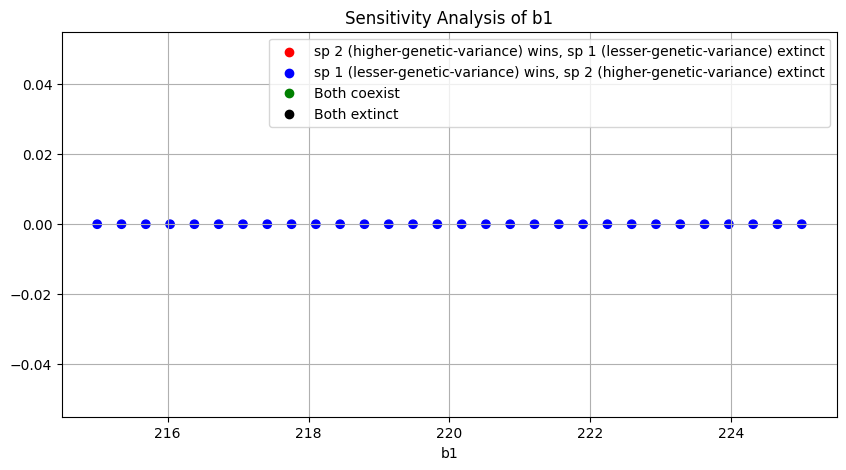

Running sensitivity analysis for b2...


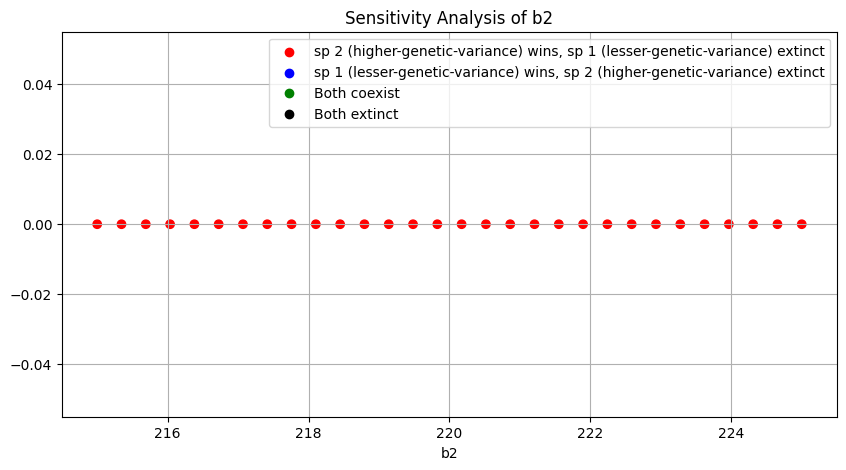

Running sensitivity analysis for alpha11...


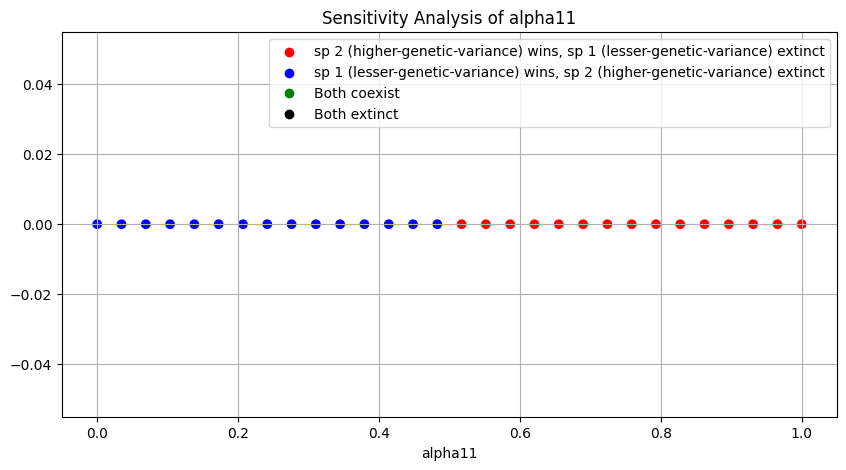

Running sensitivity analysis for alpha22...


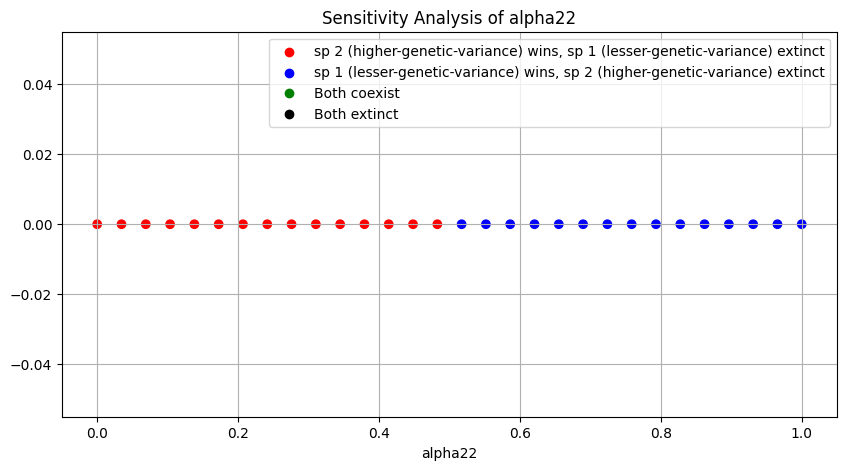

Running sensitivity analysis for alpha12...


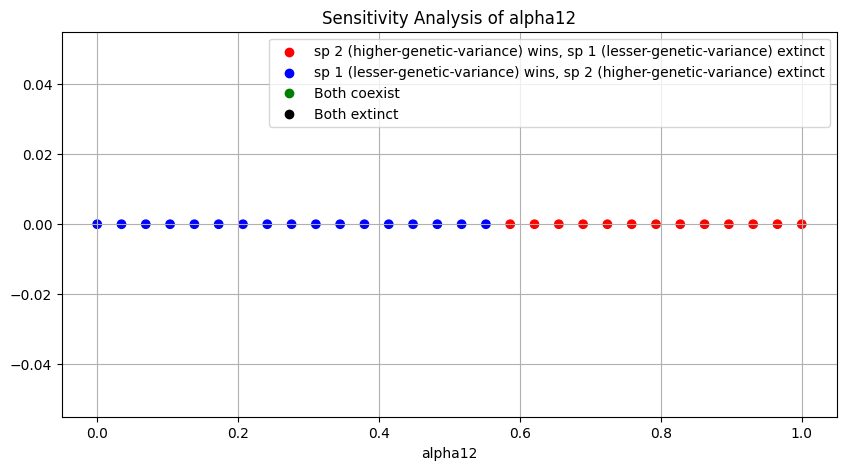

Running sensitivity analysis for alpha21...


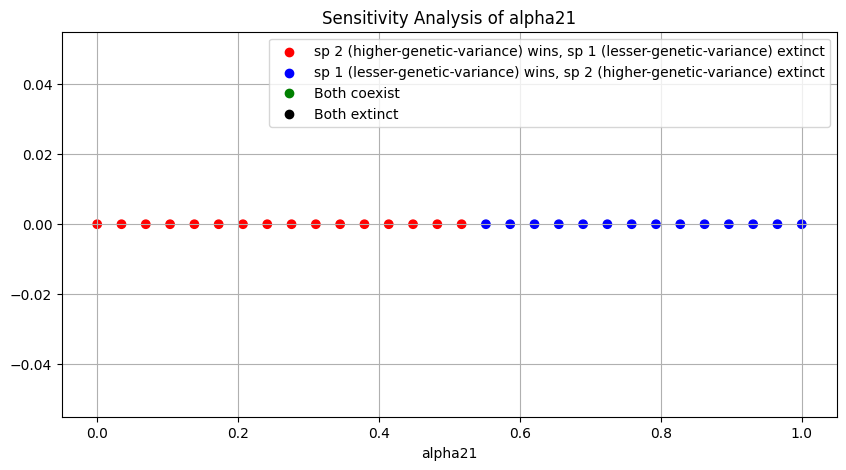

Running sensitivity analysis for z_m1_initial...


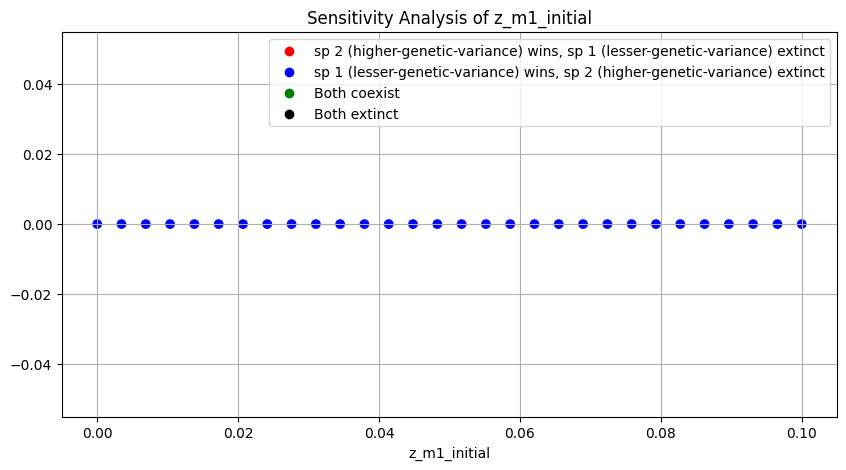

Running sensitivity analysis for z_m2_initial...


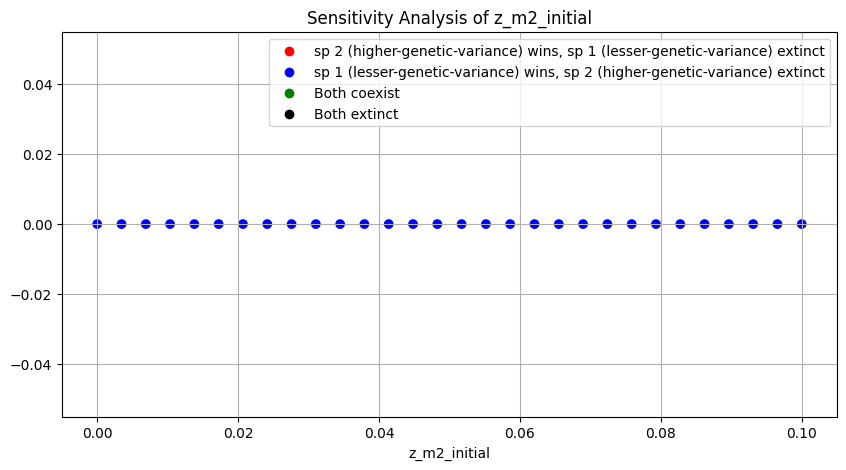

Running sensitivity analysis for cost_to_males...


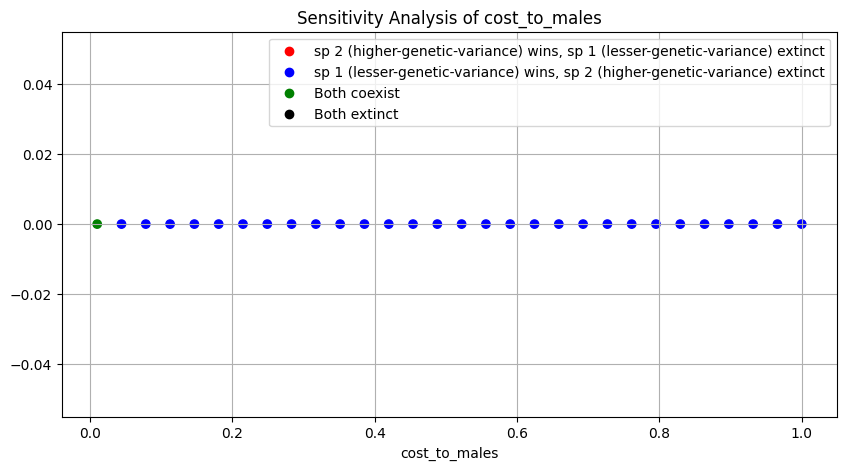

Running sensitivity analysis for strength_of_interference...


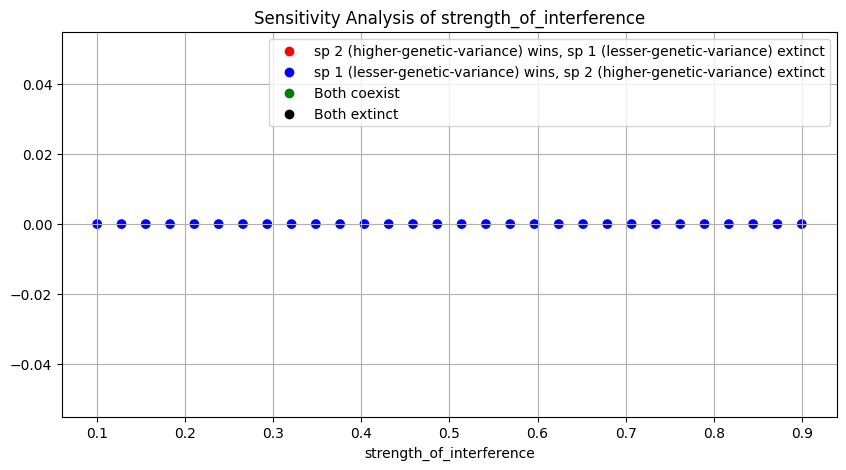

Running sensitivity analysis for V_A1...


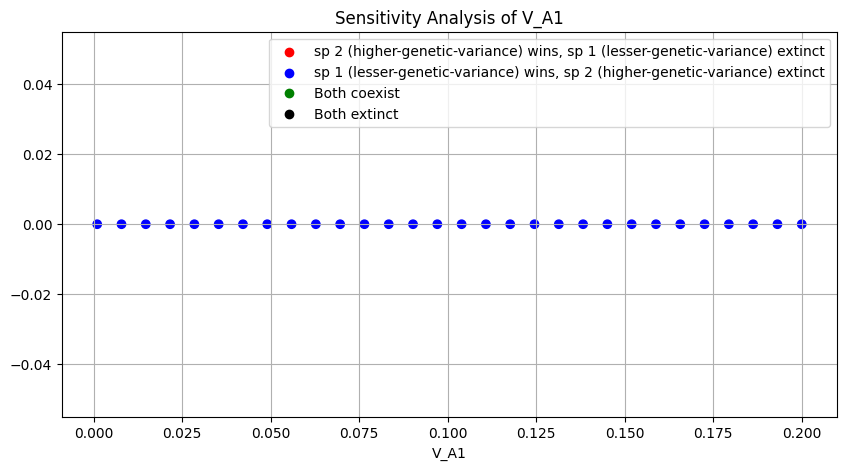

Running sensitivity analysis for V_A2...


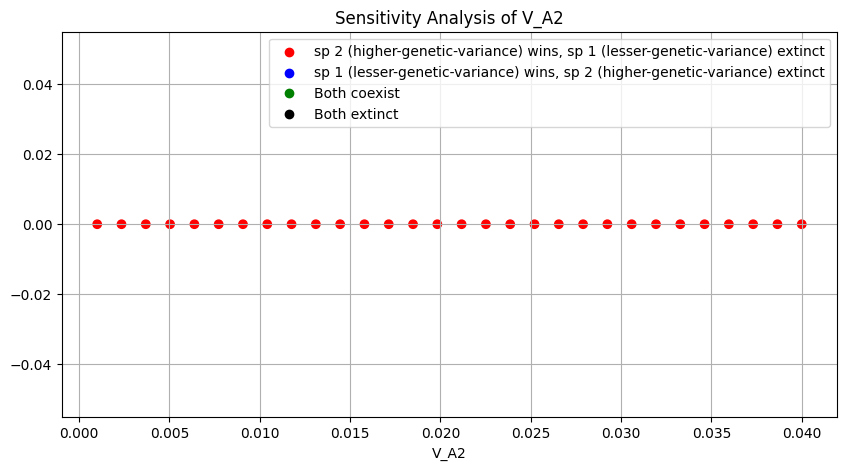

In [46]:
def plot_sensitivity_analysis(parameter_values, final_outcomes_list, parameter_name):  
        color_map = {"sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red', "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue', "both extinct"
: 'black', "both coexist": 'green'}
        
        colors = [color_map[outcome] for outcome in final_outcomes_list]
        
        plt.figure(figsize=(10, 5))
        plt.scatter(parameter_values, [0]*len(parameter_values), color=colors, marker='o')
        plt.xlabel(parameter_name)
        plt.title(f'Sensitivity Analysis of {parameter_name}')
        plt.grid(True)
        # Adding legend manually
        plt.scatter([], [], color='red', label="sp 2 (higher-genetic-variance) wins, sp 1 (lesser-genetic-variance) extinct")
        plt.scatter([], [], color='blue', label= "sp 1 (lesser-genetic-variance) wins, sp 2 (higher-genetic-variance) extinct")
        plt.scatter([], [], color='green', label='Both coexist')
        plt.scatter([], [], color='black', label='Both extinct')
        plt.legend(loc='upper right')
        plt.show()

def generate_parameters_with_varied_parameter(parameter_name, base_parameters, parameter_values):  #base parameters, parameter name taken, and the different values of that parametereter are taken
    parameters_list = []
    for value in parameter_values:   
        parameters_dict = Parameters_for_Analysis(base_parameters).__dict__.copy() #create a default instance of the Parameters_for_Analysis class and then copy the dictionary of the instance
        parameters_dict[parameter_name] = value             #Thuis dictionary is then inserted into the Parameters_for_Analysis class which creates yet abother instance
        parameters = Parameters_for_Analysis(base_parameters, **parameters_dict)
        parameters_list.append(parameters)      #all the instances are appended to a list
    return parameters_list

def run_sensitivity_analysis(parameters_list):
    final_outcomes_list = []
    for parameters in parameters_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(parameters)
        final_outcomes_list.append(final_outcome_instance.outcome)
    return final_outcomes_list

def main():
    # Base parameters

    # parameters to vary
    parameter_ranges = {                  #for each parametereter name, the range of values to vary over is definedm as a dictionary
        'b1': np.linspace(215, 225, 30),
        'b2': np.linspace(215, 225, 30),
        'alpha11': np.linspace(0, 1, 30),
        'alpha22': np.linspace(0, 1, 30),
        'alpha12': np.linspace(0, 1, 30),
        'alpha21': np.linspace(0, 1, 30),
        'z_m1_initial': np.linspace(0, 0.1, 30),
        'z_m2_initial': np.linspace(0, 0.1, 30),
        'cost_to_males': np.linspace(0.01, 1, 30),
        'strength_of_interference': np.linspace(0.1, 0.9, 30),
        'V_A1': np.linspace(0.001, 0.2, 30),
        'V_A2': np.linspace(0.001, 0.04, 30)
    }

    parameter_names = parameter_ranges.keys()   #the keys of the parameter_ranges dictionary are extracted and stored in the parameter_names list

    for parameter_name in parameter_names:      #for each parametereter, the sensitivity analysis is run and a corresponding plot is generated
        print(f"Running sensitivity analysis for {parameter_name}...")
        parameter_values = parameter_ranges[parameter_name]     #the values of the corresponding parametereter are extracted from the parameter_ranges_dictionary        
        parameters_list = generate_parameters_with_varied_parameter(parameter_name, base_parameters, parameter_values) #parameters list is a list of instances created with the varied parametereter values
        final_outcomes_list = run_sensitivity_analysis(parameters_list) 
        plot_sensitivity_analysis(parameter_values, final_outcomes_list, parameter_name)

if __name__ == "__main__":
    main()



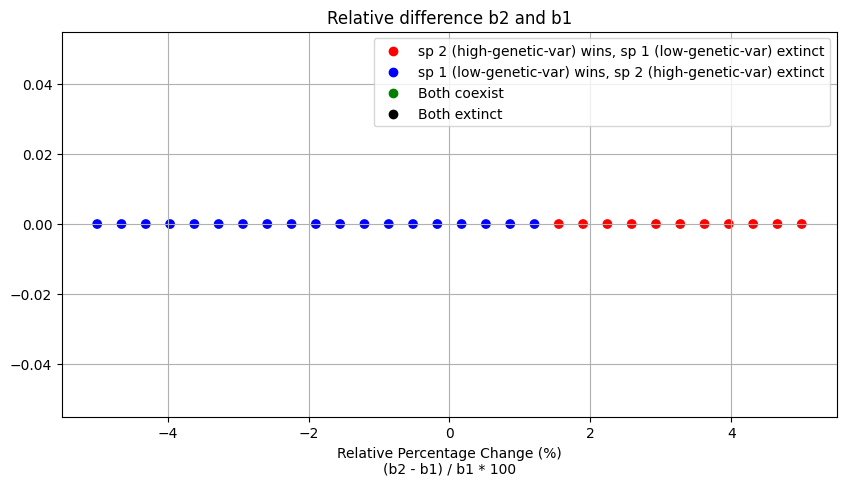

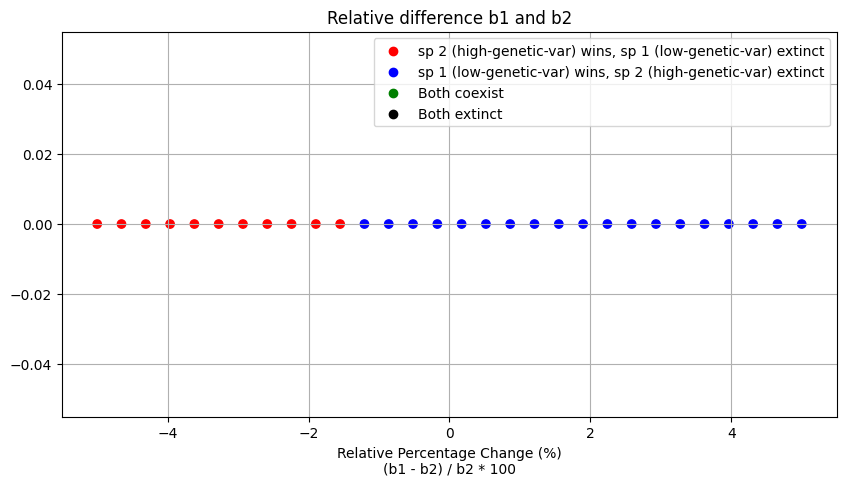

In [47]:
def plot_sensitivity_analysis_comparison(parameter_values, final_outcomes_list, parameter_name, baseline_parameter, comparison_parameter):
    color_map = {
        "sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red',
        "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue',
        "both extinct": 'black',
        "both coexist": 'green'
    }
    
    colors = [color_map[outcome] for outcome in final_outcomes_list]
    
    plt.figure(figsize=(10, 5))
    plt.scatter(parameter_values, [0]*len(parameter_values), color=colors, marker='o')
    
    plt.xlabel(f'Relative Percentage Change (%)\n({comparison_parameter} - {baseline_parameter}) / {baseline_parameter} * 100')
    plt.title(f'Relative difference {parameter_name} and {baseline_parameter}')
    
    plt.grid(True)
    
    # Legend with color labels
    plt.scatter([], [], color='red', label="sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct")
    plt.scatter([], [], color='blue', label="sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct")
    plt.scatter([], [], color='green', label='Both coexist')
    plt.scatter([], [], color='black', label='Both extinct')
    plt.legend(loc='upper right')
    
    plt.show()
def main():
    # Example usage for b2 - b1 comparison
    comparison_birth_rates = [
        ('b2', 'b1'),
        ('b1', 'b2'),
    ]


    
    for comparison_parameter, baseline_parameter in comparison_birth_rates:
        baseline_value = Parameters_for_Analysis(base_parameters).__dict__[baseline_parameter]
        parameter_values = np.linspace(baseline_value - 0.05 * baseline_value, baseline_value + 0.05 * baseline_value, 30)  # Varying comparison_parameter
        
        parameters_list = generate_parameters_with_varied_parameter(comparison_parameter, base_parameters, parameter_values)
        final_outcomes_list = run_sensitivity_analysis(parameters_list)
        
        transformed_values = ((parameter_values - baseline_value) / baseline_value) * 100
        plot_sensitivity_analysis_comparison(transformed_values, final_outcomes_list, comparison_parameter, baseline_parameter, comparison_parameter)

    # for comparison_parameter, baseline_parameter in comparisons_ks:
    #     baseline_value = Parameters_for_Analysis().__dict__[baseline_parameter]
    #     parameter_values = np.linspace(baseline_value - 0.5 * baseline_value, baseline_value + 0.5 * baseline_value, 30)

    #     parameters_list = generate_parameters_with_varied_parameter(comparison_parameter, parameter_values)
    #     final_outcomes_list = run_sensitivity_analysis(parameters_list)

    #     transformed_values = ((parameter_values - baseline_value) / baseline_value) * 100
    #     plot_sensitivity_analysis_comparison(transformed_values, final_outcomes_list, comparison_parameter, baseline_parameter, comparison_parameter)


if __name__ == "__main__":
    main()


In [48]:
'''The slow evolving species wins in the default case. What if the slow evolving species started out as a good discriminator (hence poor initial satyr effect). Fast species initially has good satyr effect, but will soon evolve to become worse'''
z_m1_initial_list = np.arange(0, 1, 0.1)
for z_m1_initial_value in z_m1_initial_list:
    parameters_temp = Parameters_for_Analysis(base_parameters = base_parameters, z_m1_initial=z_m1_initial_value)
    print(parameters_temp.__dict__)

    outcome_stats_and_plots_instance_temp_z = run_simulation_and_get_outcome_instance(parameters_temp)
    print(outcome_stats_and_plots_instance_temp_z.outcome)
    print("z_m1_initial =", parameters_temp.z_m1_initial)
    outcome_stats_and_plots_instance_temp_z.plot_population_dynamics_and_trait_evolution()


'''Insights: 
1. The slow evolving species wins in the default case.
2. Initial difference in satyr effect matters more than later (stength of satyr effect is depednant on relative population sizes, if population size of a sp. reduces its satyr effect reduces). 
    If V_A1 = 0.01, and V_A2 = 0.1, then the slow evolving species wins. 
3. There is coexistence - wtf (V_A1 = 0.1, V_A2 = 0.5)
4.  The traits crossing each other sometimes determines the outcome, sometimes not

'''


#sp1. being the better discriminatior should lose.


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.0, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct
z_m1_initial = 0.0


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.1, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct
z_m1_initial = 0.1


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.2, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct
z_m1_initial = 0.2


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.30000000000000004, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.30000000000000004


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.4, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.4


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.5, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.5


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.6000000000000001, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.6000000000000001


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.7000000000000001, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.7000000000000001


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.8, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.8


{'b1': 100, 'b2': 100, 'alpha11': 0.5, 'alpha22': 0.5, 'alpha12': 0.55, 'alpha21': 0.55, 'z_m1_initial': 0.9, 'z_m2_initial': 0, 'initial_population_species_1': 100, 'initial_population_species_2': 100, 'cost_to_males': 0.3, 'strength_of_interference': 0.1, 'V_A1': 0.5, 'V_A2': 1.5, 'num_generations': 1000}
sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct
z_m1_initial = 0.9


'Insights: \n1. The slow evolving species wins in the default case.\n2. Initial difference in satyr effect matters more than later (stength of satyr effect is depednant on relative population sizes, if population size of a sp. reduces its satyr effect reduces). \n    If V_A1 = 0.01, and V_A2 = 0.1, then the slow evolving species wins. \n3. There is coexistence - wtf (V_A1 = 0.1, V_A2 = 0.5)\n4.  The traits crossing each other sometimes determines the outcome, sometimes not\n\n'

In [49]:


def plot_2d_sensitivity_analysis_initial_pop_vs_evolvability(N2_N1_ratios, V_A2_V_A1_ratios, final_outcomes_matrix):
    color_map = {
        "sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red',
        "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue',
        "both extinct": 'black',
        "both coexist": 'green'
    }
    
    colors = np.vectorize(color_map.get)(final_outcomes_matrix)

    traces = []
    for i in range(len(N2_N1_ratios)):
        for j in range(len(V_A2_V_A1_ratios)):
            traces.append(go.Scatter(
                x=[N2_N1_ratios[i]], y=[V_A2_V_A1_ratios[j]], mode='markers',
                marker=dict(color=colors[i, j]),
                showlegend=False
            ))

    fig = go.Figure(data=traces)

    fig.update_layout(
        title='Initial Population Ratios and V_A2/V_A1 Ratios Sensitivity Analysis',
        xaxis=dict(
            title='N2/N1 Ratio',
            type='log',
            tickvals=[0.001, 0.01,0.1,0, 1, 10, 100, 1000, 10000],
            ticktext=["0.001","0.01","0.1"'0','1', '10', '100', '1000', '10000']
        ),
        yaxis=dict(
            title='V_A2/V_A1 Ratio',
            type='log',
            tickvals=[1, 10, 100, 1000],
            ticktext=['1', '10', '100', '1000']
        ),
        template='plotly',
        width=1000,
        height=800,
    )

    # Adding legend manually
    legend_labels = [
        ("sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct", 'red'),
        ("sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct", 'blue'),
        ('Both coexist', 'green'),
        ('Both extinct', 'black')
    ]

    for label, color in legend_labels:
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(color=color),
            showlegend=True,
            name=label
        ))

    pio.show(fig)

def generate_parameters_with_varied_parameters(N2_N1_ratios, V_A2_V_A1_ratios):
    parameters_list = []
    for N2_N1 in N2_N1_ratios:
        for V_A2_V_A1 in V_A2_V_A1_ratios:
            parameters_dict = Parameters_for_Analysis(base_parameters=base_parameters, V_A1=1, V_A2=1).__dict__.copy()
            parameters_dict['initial_population_species_2'] = parameters_dict['initial_population_species_1'] * N2_N1
            parameters_dict['V_A2'] = parameters_dict['V_A1'] * V_A2_V_A1
            parameters = Parameters_for_Analysis(base_parameters=base_parameters, **parameters_dict)
            parameters_list.append(parameters)
    return parameters_list

def run_sensitivity_analysis(parameters_list):
    final_outcomes_list = []
    for parameters in parameters_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(parameters)
        final_outcomes_list.append(final_outcome_instance.outcome)
    return final_outcomes_list

def main():
    N2_N1_powers = np.arange(-3, 3, 0.125)
    V_A2_V_A1_powers = np.arange(0, 3, 0.125)
    
    N2_N1_ratios = np.power(10.0, N2_N1_powers)
    V_A2_V_A1_ratios = np.power(10.0, V_A2_V_A1_powers)
    
    parameters_list = generate_parameters_with_varied_parameters(N2_N1_ratios, V_A2_V_A1_ratios)
    final_outcomes_list = run_sensitivity_analysis(parameters_list)
    
    final_outcomes_matrix = np.array(final_outcomes_list).reshape(len(N2_N1_ratios), len(V_A2_V_A1_ratios))
    
    plot_2d_sensitivity_analysis_initial_pop_vs_evolvability(N2_N1_ratios, V_A2_V_A1_ratios, final_outcomes_matrix)

if __name__ == "__main__":
    main()


In [50]:
'''2D sensitivity analysis - z_m1_initial - z_m2_initial,  and V_A2/V_A1 ratio'''


def plot_2d_sensitivity_analysis_iniitial_z_vs_evolvability(z_m1_initial_z_m2_initial_difference_list, V_A2_V_A1_ratios, final_outcomes_matrix):
    color_map = {"sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red', "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue', 
                 "both extinct": 'black', "both coexist": 'green'}
    
    colors = np.vectorize(color_map.get)(final_outcomes_matrix)

    traces = []
    for i in range(len(z_m1_initial_z_m2_initial_difference_list)):
        for j in range(len(V_A2_V_A1_ratios)):
            traces.append(go.Scatter(
                x=[z_m1_initial_z_m2_initial_difference_list[i]], y=[V_A2_V_A1_ratios[j]], mode='markers',
                marker=dict(color=colors[i, j]),
                showlegend=False
            ))

    fig = go.Figure(data=traces)

    fig.update_layout(
        title='Initial Discrimination Difference and V_A2/V_A1 Ratio Sensitivity Analysis',
    

        xaxis=dict(
            title='N2/N1 Ratio',
            tickvals = np.round(np.arange(0, 1, 0.1), 1),
            ticktext = np.round(np.arange(0, 1, 0.1), 1)
        ),
        yaxis=dict(
            title='V_A2/V_A1 Ratio',
            type='log',
            tickvals=[1, 10, 100, 1000],
            ticktext=['1', '10', '100', '1000']
        ),
        template='plotly',
        width=1000,
        height=800,
        )

    # Adding legend manually
    legend_labels = [
        ("sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct", 'red'),
        ("sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct", 'blue'),
        ('Both coexist', 'green'),
        ('Both extinct', 'black')
    ]

    for label, color in legend_labels:
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(color=color),
            showlegend=True,
            name=label
        ))

    pio.show(fig)  # Use pio.show to display the plot

def generate_parameters_with_varied_parameters(z_m1_initial_z_m2_initial_difference_list, V_A2_V_A1_ratios):
    parameters_list = []
    for z_m1_initial_z_m2_initial_difference in z_m1_initial_z_m2_initial_difference_list:
        for V_A2_V_A1 in V_A2_V_A1_ratios:
            parameters_dict = Parameters_for_Analysis(base_parameters = base_parameters, V_A1=0.01, V_A2=0.01).__dict__.copy()
            parameters_dict['z_m1_initial'] = parameters_dict['z_m2_initial'] + z_m1_initial_z_m2_initial_difference
            parameters_dict['V_A2'] = parameters_dict['V_A1'] * V_A2_V_A1
            parameters = Parameters_for_Analysis(base_parameters = base_parameters, **parameters_dict)
            parameters_list.append(parameters)
    return parameters_list

def run_sensitivity_analysis(parameters_list):
    final_outcomes_list = []
    for parameters in parameters_list:
        final_outcome_instance = run_simulation_and_get_outcome_instance(parameters)
        final_outcomes_list.append(final_outcome_instance.outcome)
    return final_outcomes_list

def main():
    z_m1_initial_z_m2_initial_difference_list = np.arange(0, 1, 0.1)
    V_A2_V_A1_powers = np.arange(0, 3, 0.125)
    
    V_A2_V_A1_ratios = np.power(10.0, V_A2_V_A1_powers)
    
    parameters_list = generate_parameters_with_varied_parameters(z_m1_initial_z_m2_initial_difference_list, V_A2_V_A1_ratios)
    final_outcomes_list = run_sensitivity_analysis(parameters_list)
    
    final_outcomes_matrix = np.array(final_outcomes_list).reshape(len(z_m1_initial_z_m2_initial_difference_list), len(V_A2_V_A1_ratios))
    
    plot_2d_sensitivity_analysis_iniitial_z_vs_evolvability(z_m1_initial_z_m2_initial_difference_list, V_A2_V_A1_ratios, final_outcomes_matrix)

if __name__ == "__main__":
    main()


In [51]:
def initial_population_from_carrying_capacity(b1, alpha11, alpha12, b2, alpha22, alpha21):
    carrying_capacity_species_1 = round((b1 - 1)/(alpha11 + alpha12))
    carrying_capacity_species_2 = round((b2 - 1)/(alpha22 + alpha21))

    initial_population = min(carrying_capacity_species_1, carrying_capacity_species_2)

    return initial_population

In [52]:
'''robustness of the outcome to perturbations in the parameters'''

'robustness of the outcome to perturbations in the parameters'

In [53]:
# Define parameter ranges with limited values
strength_of_interference_values = np.round(np.linspace(0, 1, 4),3)
cost_to_males_values = np.round(np.linspace(0.1, 0.9, 4),3)
interspecific_competition_multipler = np.round(np.linspace(0, 2, 3),3)
V_A1_values = np.round(np.linspace(0.01, 0.5, 3),3)


genetic_multiplier = 4



# Create all parameter combinations
parameter_combinations = itertools.product(
    strength_of_interference_values,
    cost_to_males_values, 
    interspecific_competition_multipler,
    V_A1_values
)

# Create an Excel writer object
writer = pd.ExcelWriter('parameter_combinations_test_4D.xlsx', engine='xlsxwriter')


# Write combinations to separate sheets in the Excel file
chunk_size = 10000
data = []
sheet_count = 1

for idx, combo in enumerate(parameter_combinations):
    strength_of_interference, cost_to_males, interspecific_competition_multipler, V_A1 = combo
    V_A2 = V_A1 * genetic_multiplier  # Calculate V_A2
    alpha12 = alpha21 = base_parameters.alpha11*interspecific_competition_multipler
    data.append((strength_of_interference, cost_to_males, V_A1, V_A2, alpha12, alpha21))
    
    if (idx + 1) % chunk_size == 0:
        df_chunk = pd.DataFrame(data, columns=[
            'strength_of_interference', 'cost_to_males', 
              'V_A1', 'V_A2', 
             'alpha12', 'alpha21'
        ])
        df_chunk.to_excel(writer, sheet_name=f'Sheet{sheet_count}', index=False)
        sheet_count += 1
        data = []

# Write any remaining data
if data:
    df_chunk = pd.DataFrame(data, columns=[
        'strength_of_interference', 'cost_to_males', 
          'V_A1', 'V_A2', 
        'alpha12', 'alpha21'
    ])
    df_chunk.to_excel(writer, sheet_name=f'Sheet{sheet_count}', index=False)

# Save the Excel file
writer.close()

In [54]:
import warnings
import pandas as pd

def get_outcome(row):
    try:
        # Define parameters for the analysis
        parameters_temp = Parameters_for_Analysis(
            base_parameters=base_parameters,
            alpha12=row['alpha12'],
            alpha21=row['alpha21'],
            strength_of_interference=row['strength_of_interference'],
            cost_to_males=row['cost_to_males'],
            initial_population_species_1=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            initial_population_species_2=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            V_A1=row['V_A1'],
            V_A2=row['V_A2']
        )

        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", RuntimeWarning)
            
            # Run simulation and get outcome
            outcome_stats_and_plots_instance_temp_z = run_simulation_and_get_outcome_instance(parameters_temp)
            
            # Check for warnings
            if len(w) > 0:
                for warning in w:
                    if issubclass(warning.category, RuntimeWarning):
                        print("RuntimeWarning encountered with parameters:")
                        print(row.to_dict())
                        print(parameters_temp.__dict__)
                        # print(f"Warning: {warning.message}")

            return outcome_stats_and_plots_instance_temp_z.outcome
    
    except Exception as e:
        print("An error occurred with parameters:")
        print(row.to_dict())
        print(f"Error: {e}")
        return None
    


xlsx = pd.ExcelFile('parameter_combinations_test_4D.xlsx')

# Create a writer object to save the updated Excel file
with pd.ExcelWriter('updated_parameter_combinations_4D.xlsx') as writer:
    # Process each sheet
    for sheet_name in xlsx.sheet_names:
        # Load sheet data
        chunk = pd.read_excel(xlsx, sheet_name=sheet_name)
        
        # Apply get_outcome to each row and store the results in a new column
        chunk['outcome'] = chunk.apply(get_outcome, axis=1)
        
        # Write the updated chunk to the new Excel file
        chunk.to_excel(writer, sheet_name=sheet_name, index=False)

# Display the results (for the newly created Excel file)
updated_xlsx = pd.ExcelFile('updated_parameter_combinations_4D.xlsx')
for sheet_name in updated_xlsx.sheet_names:
    df = pd.read_excel(updated_xlsx, sheet_name=sheet_name)
    # print(f"Sheet: {sheet_name}")
    # print(df.head())




In [55]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load the updated Excel file
updated_xlsx = pd.ExcelFile('updated_parameter_combinations_4D.xlsx')

# Read all sheets into a single DataFrame
all_data = pd.concat(pd.read_excel(updated_xlsx, sheet_name=sheet) for sheet in updated_xlsx.sheet_names)

# Define the color mapping based on outcomes
color_mapping = {
    "sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red', 
    "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue', 
    "both extinct": 'black', 
    "both coexist": 'green'
}

# Apply the color mapping to the 'outcome' column
all_data['color'] = all_data['outcome'].map(color_mapping)

# Get unique values for V_A1 and interspecific_competition
V_A1_values = sorted(all_data['V_A1'].unique())
interspecific_competition_values = sorted(all_data['alpha12'].unique())

# Create subplots with each V_A1 value as a row and each interspecific_competition as a column
fig = make_subplots(
    rows=len(V_A1_values), 
    cols=len(interspecific_competition_values),
    # shared_xaxes=True,
    shared_yaxes=True
)

# Create a single trace per outcome for the legend
legend_traces = {
    outcome: go.Scatter(
        x=[None], y=[None],  # Empty data to create a legend entry only
        mode='markers',
        marker=dict(color=color, size=8),
        name=outcome
    )
    for outcome, color in color_mapping.items()
}

# Generate scatter plots for each combination of V_A1 and interspecific_competition
for i, V_A1 in enumerate(V_A1_values, start=1):
    for j, interspecific_competition in enumerate(interspecific_competition_values, start=1):
        # Filter data for the specific V_A1 and interspecific_competition
        filtered_data = all_data[(all_data['V_A1'] == V_A1) & 
                                 (all_data['alpha12'] == interspecific_competition)]
        
        # Create scatter plot traces for each outcome
        for outcome, color in color_mapping.items():
            outcome_data = filtered_data[filtered_data['outcome'] == outcome]
            trace = go.Scatter(
                x=outcome_data['strength_of_interference'],
                y=outcome_data['cost_to_males'],
                mode='markers',
                marker=dict(color=color, size=8),
                name=outcome,
                showlegend=False  # Hide individual traces from the legend
            )

            fig.add_trace(trace, row=i, col=j)
            fig.update_yaxes(title_text='a')
            fig.update_xaxes(title_text='s')


# Add the legend traces to the figure (ensuring they appear only once)
for trace in legend_traces.values():
    fig.add_trace(trace, row=1, col=1)

# Update layout for better spacing and readability
fig.update_layout(
    title="Scatter Plots of Outcomes",
    height=300 * len(V_A1_values),
    width=300 * len(interspecific_competition_values),
    showlegend=True
)

# Set x-axis and y-axis titles for all subplots

fig.show()


In [56]:
def perturbation_test(row):
    
    # Create a copy of the parameters from the row
    perturbed_parameters = Parameters_for_Analysis(
            base_parameters=base_parameters,
            alpha12=row['alpha12'],
            alpha21=row['alpha21'],
            strength_of_interference=row['strength_of_interference'],
            cost_to_males=row['cost_to_males'],
            initial_population_species_1=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            initial_population_species_2=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            V_A1=row['V_A1'],
            V_A2=row['V_A2']
        )

    
    # Apply perturbations
    # perturbed_parameters.alpha12 *= 1.1
    # perturbed_parameters.z_m1_initial += 0.3
    # perturbed_parameters.b2 *= 1.1
    perturbed_parameters.initial_population_species_2 *= 1.3
    
    # Run simulation with perturbed parameters
    outcome_instance = run_simulation_and_get_outcome_instance(perturbed_parameters)
    
    # Expected outcome
    expected_outcome = 'sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct'
    
    # Check if the outcome is as expected
    if outcome_instance.outcome == expected_outcome:
        return "passed"
    else:
        return "failed"

def apply_perturbation_test(row):
    if row['outcome'] == 'sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct':
        return perturbation_test(row)
    return None

# Load the updated Excel file
updated_xlsx = pd.ExcelFile('updated_parameter_combinations_4D.xlsx')

total_passed = 0  # Initialize counter for passed perturbation tests
total_failed = 0  # Initialize counter for failed perturbation tests

# Create a writer object to save the perturbation test results
with pd.ExcelWriter('perturbation_test_results_4D.xlsx') as writer:
    for sheet_name in updated_xlsx.sheet_names:
        df = pd.read_excel(updated_xlsx, sheet_name=sheet_name)
        
        # Apply perturbation test to rows where outcome matches the condition
        df['perturbation_test'] = df.apply(apply_perturbation_test, axis=1)
        
        # Count the number of passed and failed perturbation tests
        test_counts = df['perturbation_test'].value_counts()
        passed_count = test_counts.get('passed', 0)
        failed_count = test_counts.get('failed', 0)
        
        total_passed += passed_count
        total_failed += failed_count
        
        # Write the updated data with perturbation test results
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # Print the count of passed and failed perturbation tests for each sheet

# Print the total number of passed and failed perturbation tests across all sheets
print(f"Total number of passed perturbation tests: {total_passed}")
print(f"Total number of failed perturbation tests: {total_failed}")


Total number of passed perturbation tests: 3
Total number of failed perturbation tests: 73


I need to figure out how to do update the x and y axis properly. I basically need a way to write down for the bigplot

In [57]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load the updated Excel file
updated_xlsx = pd.ExcelFile('updated_parameter_combinations_4D.xlsx')

# Read all sheets into a single DataFrame
all_data = pd.concat(pd.read_excel(updated_xlsx, sheet_name=sheet) for sheet in updated_xlsx.sheet_names)

# Define the color mapping based on outcomes
color_mapping = {
    "sp 2 (high-genetic-var) wins, sp 1 (low-genetic-var) extinct": 'red', 
    "sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct": 'blue', 
    "both extinct": 'black', 
    "both coexist": 'white',
    "pass": 'darkgreen',
    "fail": 'lightgreen'
}

# Function to apply perturbation test and classify results
def perturbation_test(row):
    # Create a copy of the parameters from the row
    perturbed_parameters = Parameters_for_Analysis(
            base_parameters=base_parameters,
            alpha12=row['alpha12'],
            alpha21=row['alpha21'],
            strength_of_interference=row['strength_of_interference'],
            cost_to_males=row['cost_to_males'],
            initial_population_species_1=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            initial_population_species_2=initial_population_from_carrying_capacity(
                base_parameters.b1, base_parameters.alpha11, row['alpha12'],
                base_parameters.b2, base_parameters.alpha22, row['alpha21']
            ),
            V_A1=row['V_A1'],
            V_A2=row['V_A2']
        )

    # Apply perturbations
    
    # perturbed_parameters.z_m1_initial += 0.1
    perturbed_parameters.initial_population_species_2 *= 1.1
    
    # Run simulation with perturbed parameters
    outcome_instance = run_simulation_and_get_outcome_instance(perturbed_parameters)
    
    # Expected outcome
    expected_outcome = 'sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct'
    
    # Check if the outcome is as expected
    if outcome_instance.outcome == expected_outcome:
        return "pass"
    else:
        return "fail"

def apply_perturbation_test(row):
    if row['outcome'] == 'sp 1 (low-genetic-var) wins, sp 2 (high-genetic-var) extinct':
        return perturbation_test(row)
    return None

# Apply perturbation test to the data
all_data['perturbation_test'] = all_data.apply(apply_perturbation_test, axis=1)

# Map the perturbation test results to the color column
all_data['color'] = all_data.apply(
    lambda row: color_mapping[row['perturbation_test']] if row['perturbation_test'] else color_mapping[row['outcome']], axis=1
)

# Get unique values for V_A1 and interspecific_competition
V_A1_values = sorted(all_data['V_A1'].unique(), reverse=True)

interspecific_competition_values = sorted(all_data['alpha12'].unique())

# Create subplots with each V_A1 value as a row and each interspecific_competition as a column
fig = make_subplots(
    rows=len(V_A1_values), 
    cols=len(interspecific_competition_values),
    # shared_xaxes=True,
    shared_yaxes=True
)

# fig.update_yaxes(title_text='V_A1')
# fig.update_xaxes(title_text='Interspecific Competition')


# Create a single trace per outcome for the legend
legend_traces = {
    outcome: go.Scatter(
        x=[None], y=[None],  # Empty data to create a legend entry only
        mode='markers',
        marker=dict(color=color, size=8),
        name=outcome
    )
    for outcome, color in color_mapping.items()
}

# Generate scatter plots for each combination of V_A1 and interspecific_competition
for i, V_A1 in enumerate(V_A1_values, start=1):
    for j, interspecific_competition in enumerate(interspecific_competition_values, start=1):
        # Filter data for the specific V_A1 and interspecific_competition
        filtered_data = all_data[(all_data['V_A1'] == V_A1) & 
                                 (all_data['alpha12'] == interspecific_competition)]
        
        # Create scatter plot traces for each outcome
        for outcome, color in color_mapping.items():
            outcome_data = filtered_data[filtered_data['outcome'] == outcome]
            trace = go.Scatter(
                x=outcome_data['strength_of_interference'],
                y=outcome_data['cost_to_males'],
                mode='markers',
                marker=dict(color=color, size=8),
                name=outcome,
                showlegend=False,  # Hide individual traces from the legend
                hovertemplate=(
                    'V_A1: %{customdata[0]}<br>'
                    'Interspecific Competition: %{customdata[1]}<br>'
                    'Strength of Interference: %{x}<br>'
                    'Cost to Males: %{y}'
                ),
                customdata=outcome_data[['V_A1', 'alpha12']].values
            )

            fig.add_trace(trace, row=i, col=j)


        # Add traces for perturbation test results
        for result in ['pass', 'fail']:
            result_data = filtered_data[filtered_data['perturbation_test'] == result]
            trace = go.Scatter(
                x=result_data['strength_of_interference'],
                y=result_data['cost_to_males'],
                mode='markers',
                marker=dict(color=color_mapping[result], size=8),
                name=result,
                showlegend=False,  # Hide individual traces from the legend
                hovertemplate=(
                    'V_A1: %{customdata[0]}<br>'
                    'Interspecific Competition: %{customdata[1]}<br>'
                    'Strength of Interference: %{x}<br>'
                    'Cost to Males: %{y}'
                ),
                customdata=result_data[['V_A1', 'alpha12']].values
            )

            fig.add_trace(trace, row=i, col=j)

            fig.update_yaxes(title_text='a')
            fig.update_xaxes(title_text='s')


# Add the legend traces to the figure (ensuring they appear only once)
for trace in legend_traces.values():
    fig.add_trace(trace, row=1, col=1)

# Update layout for better spacing and readability
fig.update_layout(
    title="Scatter Plots of Outcomes",
    height=300 * len(V_A1_values),
    # width=300 * len(interspecific_competition_values),
    showlegend=True,
)



# Set x-axis and y-axis titles for all subplots
# fig.update_yaxes(title_text='Cost to Males')
# fig.update_xaxes(title_text='Strength of Interference')

fig.show()


heatmap. change grey. Remove grid. 